In [1]:
import tensorflow as tf

In [2]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
tf.keras.backend.set_session(tf.Session(config=sess_config))

In [3]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_image(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [4]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')

In [5]:
image_path = "/data2/pancreas/Nifti_data/image"
label_path = "/data2/pancreas/Nifti_data/label"

In [6]:
resec0_names = info.groupby("resection").get_group(0).case_id.unique()
resec1_names = info.groupby("resection").get_group(1).case_id.unique()

#combine resec0 and resec1 and shuffle
resec = np.concatenate([resec0_names,resec1_names], axis = 0)



In [7]:
np.random.shuffle(resec)

In [8]:
y = np.zeros((len(resec), 1))
for idx, name in enumerate(resec):
    y[idx] = info[info.case_id == name].resection



In [9]:
print(np.where(y[-30:] == 1)[0].shape)
print(np.where(y[-50:-30] == 1)[0].shape)

(15,)
(8,)


In [11]:
# #check the num. of image in terms of z-axis
# img_shape = []
# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))
    
#     img_shape.append(img.shape[2])
#     del img



In [17]:
# label_t = load_image(os.path.join(label_path, "LB_"+resec[0]+".nii.gz"))
# np.max(np.where(label_t != 0)[2])

72

In [10]:
#determine the size of cube using label-img
shape0 = np.zeros((len(resec), 2))
shape1 = np.zeros((len(resec), 2))
shape2 = np.zeros((len(resec), 2))
for i, name in enumerate(resec) :
    label = load_image(os.path.join(label_path, "LB_"+name+".nii.gz"))
    shape0[i][0] = np.min(np.where(label != 0)[0])
    shape0[i][1] = np.max(np.where(label != 0)[0])
    shape1[i][0] = np.min(np.where(label != 0)[1])
    shape1[i][1] = np.max(np.where(label != 0)[1])
    shape2[i][0] = np.min(np.where(label != 0)[2])
    shape2[i][1] = np.max(np.where(label != 0)[2])
    del label

In [36]:
# label_t = load_image(os.path.join(label_path, "LB_"+resec[0]+".nii.gz"))

In [46]:
# shape0 = pd.read_csv("shape0.csv")
# shape1 = pd.read_csv("shape1.csv")
# shape2 = pd.read_csv("shape2.csv")

In [59]:
# shape = np.swapaxes(np.array([shape0["0"], shape0["1"], shape1["0"], shape1["1"], shape2["0"], shape2["1"]]), 0, 1)

In [11]:
shape = np.concatenate([shape0, shape1, shape2], axis = 1)

In [17]:
np.save( "shape.npz", shape)

In [8]:
shape = np.load("shape.npz.npy")

In [9]:
resec = np.load("resec.npy")

In [10]:
y = np.load("resec_y.npy")

In [7]:
np.save("resec", resec)

NameError: name 'resec' is not defined

In [23]:
np.save("resec_y", y)

In [11]:
#New
def extract_cube(r, img):#cube 360, 300, 110 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((360, 300, 110))
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp

array([ 72., 324., 145., 306.,   9.,  24.])

In [22]:
#test extract_cube
label_t = extract_cube(shape[0, :], load_image(os.path.join(label_path, "LB_"+resec[0]+".nii.gz")))

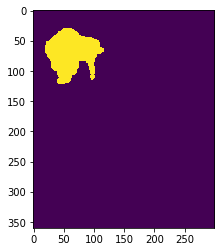

In [35]:
plt.imshow(label_t[..., 1])
plt.show()
del label_t

In [45]:
shape[np.array(range(10))[0]]

array([ 72., 324., 145., 306.,   9.,  24.])

In [12]:
import pandas as pd
#y_idx => for construct (500, 1) vector
map_df = pd.DataFrame(data={'resec_name': resec, 'shape': np.array(range(182)), 'target':y.reshape(182)})

In [13]:
from keras.models import Model#, load_model
from keras import layers as klayers
from keras.optimizers import Adam
from keras import utils as kutils
from keras import backend as K
from keras.callbacks import ModelCheckpoint



from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
#import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

#init_notebook_mode(connected=True)
%matplotlib inline


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate,  MaxPool2D
# from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline





Using TensorFlow backend.


In [14]:
from keras.utils import to_categorical

class resec_Generator1(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print("enter0")
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        X1 = np.zeros((  self.batch_size, 180, 300, 100, 1)) 
        X2 = np.zeros((  self.batch_size, 180, 300, 100, 1)) 
        y = np.zeros((self.batch_size))

        # Generate data
        cnt = 0
        
        for i, row in batch_mapping_df.iterrows():
            img = extract_cube(shape[row['shape']], load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            X1[ cnt, :, :, :, 0] = img[:180, :, :]
            X2[ cnt, :, :, :, 0] = img[180:, :, :]
            #img = clip_img(load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            #print("resec_name =", row['resec_name'])
#             for j in range(40):
#                 #print("img shape =", img.shape)
#                 #print("j =", j)
#                 X[j][cnt, :, :, :, 0] = extract_cube(img, j)
            y[cnt] = row['target']

#             position = extract_position(row['ref_idx'], row['point_idx'])
#             tmp_cube = extract_cube(position, row['ref_idx'])
#             if (tmp_cube.shape == (19, 19, 19)):
#                 X[cnt, :, :, :, 0] = extract_cube(position, row['ref_idx'])
#             else:
#                 X[cnt, :, :, :, 0] = np.zeros((19, 19, 19))
#             y_idx = row['y_idx']
#             radius = ref[row['ref_idx']][row['point_idx'], 3]
#             y1[cnt, y_idx] = 1
#             y2[cnt, 0] = radius
            cnt += 1
        #print(X[5])
        return [X1, X2], y

# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))

In [90]:
# pd.DataFrame(shape2).to_csv("shape2.csv")

In [91]:
del model

In [15]:
from keras import metrics
tmp_x = Input((180, 300, 100, 1))
x = Conv3D(filters=32, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(tmp_x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)


tmp_y = Input((180, 300, 100, 1))
y = Conv3D(filters=32, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(tmp_y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = MaxPool3D()(y)

y = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = MaxPool3D()(y)

y = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPool3D()(y)

y = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPool3D()(y)

y = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPool3D()(y)

x = concatenate([x, y], axis = 4)


x = Flatten()(x)
x = Dense(units=800, kernel_initializer='normal', activation='elu')(x)
x = Dense(units=100, kernel_initializer='normal', activation='relu')(x)
x = Dense(units=1, kernel_initializer='normal', activation='sigmoid')(x)

model = Model(inputs=[tmp_x, tmp_y], outputs=x)
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [metrics.binary_accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 300, 100 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 180, 300, 100 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 178, 298, 98, 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 178, 298, 98, 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [16]:
batch_size = 1
v_generator = resec_Generator1(map_df[:-50], batch_size=batch_size)
validation_generator = resec_Generator1(map_df[-50:-30], batch_size=batch_size)

In [17]:
history = model.fit_generator(v_generator,
                              epochs=15, validation_data=validation_generator)

Epoch 1/15
132/132 [==============================] - 524s 4s/step - loss: 0.8634 - binary_accuracy: 0.5606 - val_loss: 0.6251 - val_binary_accuracy: 0.5500
Epoch 2/15
132/132 [==============================] - 497s 4s/step - loss: 0.6776 - binary_accuracy: 0.6212 - val_loss: 0.7643 - val_binary_accuracy: 0.4500
Epoch 3/15
132/132 [==============================] - 496s 4s/step - loss: 0.6446 - binary_accuracy: 0.6515 - val_loss: 0.9886 - val_binary_accuracy: 0.5000
Epoch 4/15
132/132 [==============================] - 500s 4s/step - loss: 0.5991 - binary_accuracy: 0.6364 - val_loss: 1.1452 - val_binary_accuracy: 0.4500
Epoch 5/15
132/132 [==============================] - 503s 4s/step - loss: 0.5182 - binary_accuracy: 0.7348 - val_loss: 1.7225 - val_binary_accuracy: 0.4500
Epoch 6/15
132/132 [==============================] - 497s 4s/step - loss: 0.3923 - binary_accuracy: 0.8409 - val_loss: 1.6166 - val_binary_accuracy: 0.4500
Epoch 7/15
132/132 [==============================] - 500s

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


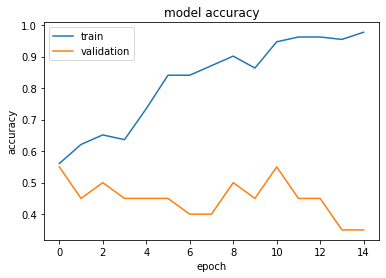

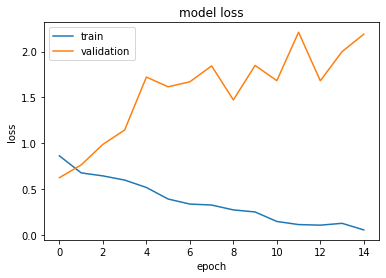

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
# print(np.max(shape0[:, 1] - shape0[:, 0]))
# print(np.max(shape1[:, 1] - shape1[:, 0]))
# print(np.max(shape2[:, 1] - shape2[:, 0]))

#cube shape : 360, 300, 110

356.0
289.0
105.0


In [31]:
# print(np.min(shape0[:, 0]), np.max(shape0[:, 1]))
# print(np.min(shape1[:, 0]), np.max(shape1[:, 1]))
# print(np.min(shape2[:, 0]), np.max(shape2[:, 1]))

52.0 452.0
57.0 395.0
2.0 605.0


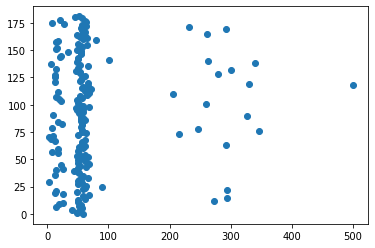

In [32]:
plt.scatter(shape2[:, 0], list(range(shape2.shape[0])))

In [24]:
#find the center point for each image using label
med0 = []
med1 = []
med2 = []
for i, name in enumerate(resec) :
    label = load_image(os.path.join(label_path, "LB_"+name+".nii.gz"))
    med0.append(np.median(np.where(label != 0)[0]))
    med1.append(np.median(np.where(label != 0)[1]))
    med2.append(np.median(np.where(label != 0)[2]))

In [ ]:
from keras.utils import to_categorical

class resec_Generator(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print("enter0")
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        X = [np.zeros((self.batch_size, 60, 40, 100, 1)) for i in range(40)]
        y = np.zeros((self.batch_size))

        # Generate data
        cnt = 0
        
        for i, row in batch_mapping_df.iterrows():
            img = clip_img(load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            #print("resec_name =", row['resec_name'])
            for j in range(40):
                #print("img shape =", img.shape)
                #print("j =", j)
                X[j][cnt, :, :, :, 0] = extract_cube(img, j)
            y[cnt] = row['target']

#             position = extract_position(row['ref_idx'], row['point_idx'])
#             tmp_cube = extract_cube(position, row['ref_idx'])
#             if (tmp_cube.shape == (19, 19, 19)):
#                 X[cnt, :, :, :, 0] = extract_cube(position, row['ref_idx'])
#             else:
#                 X[cnt, :, :, :, 0] = np.zeros((19, 19, 19))
#             y_idx = row['y_idx']
#             radius = ref[row['ref_idx']][row['point_idx'], 3]
#             y1[cnt, y_idx] = 1
#             y2[cnt, 0] = radius
            cnt += 1
        #print(X[5])
        return X, y

# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))

In [ ]:
def extract_cube(center, img):#cube 360, 300, 110
    
    xyz = [360, 300, 110]
    pad_zero = np.zeros((6, 1))
    for i, thre in enumerate(xyz):
        line1 = center[i] - int(thre/2)
        line2 = center[i] + int(thre/2)
        for j, line in enumerate([line1, line2]):
            if (0<=line<=img.shape[i]):
                continue
            elif (line < 0):
                pad_zero[i*2+j] = -line
            elif (line > img.shape[i]):
                pad_zero[i*2+j] = img.shape[i] - line 
    tmp_img = np.zeros((360, 300, 110))
    for i, pad in enumerate(pad_zero):
        axis = i%3
        if axis == 0:
            
        if axis == 1:
            
        if axis == 2:
            
            
            
            
        

        

    
    
    
    
#     shape_size = [360, 300, 110]
#     tmp_img = np.zeros((360, 300, 110))
#     for curr_axis in range(3):
#         if img.shape[curr_axis] < shape_size[curr_axis]:
                
#         else:
                
    return img

In [33]:
centers = np.swapaxes(np.array([med0, med1, med2]), 0, 1)

In [ ]:
#100:400 200:360 
#60:5, 40:4, +-20 median   24 inouts 
def clip_img(img):# make image to be in shape of (300, 160, 200)
    img = img[100:400, 200:360, :]
    _med = int(img.shape[2]/2)
    tmp_img = np.zeros((300, 160, 200))
    if img.shape[2] < 200:
        a = img.shape[2]
        tmp_img[:, :, 100-_med : 100-_med+a] = img
    else:
        tmp_img = img[:, :, _med-100 : _med+100 ]
    img = tmp_img
    del tmp_img
    return img
    
def extract_cube(img, i):#Input((60, 40, 30, 1)) ; the i-th cube
    j = i%5
    k = i%4
    l = i%2
    #print(img[j*60:(j+1)*60, k*40:(1+k)*40, l*30:(l+1)*30].shape)
    return img[j*60:(j+1)*60, k*40:(1+k)*40, l*100:(l+1)*100]
    
    
import pandas as pd
#y_idx => for construct (500, 1) vector
map_df = pd.DataFrame(data={'resec_name': resec, 'target':y.reshape(182)})

In [ ]:
batch_size = 1
v_generator = resec_Generator(map_df[:-50], batch_size=batch_size)
validation_generator = resec_Generator(map_df[-50:-30], batch_size=batch_size)

In [20]:
# history = model.fit_generator(v_generator,
#                               epochs=4, validation_data=validation_generator)